# Google Cloud CMIP6 Public Data: Basic Python Example

This notebooks shows how to query the catalog and load the data using python

In [1]:
import pip
pip.main(["install","matplotlib", "pandas", "xarray", "zarr", "gcsfs", "cftime", "dask[array]", "toolz", "nc-time-axis"])

Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.


0

In [2]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import zarr
import gcsfs
import cftime
import dask
import toolz


xr.set_options(display_style='html')
%matplotlib inline
%config InlineBackend.figure_format = 'retina' 

In [3]:
plt.rcParams['figure.figsize'] = 12, 6

## Browse Catalog

The data catatalog is stored as a CSV file. Here we read it with Pandas.

In [4]:
df = pd.read_csv('https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv')
df.head()

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year
0,AerChemMIP,AS-RCEC,TaiESM1,histSST,r1i1p1f1,AERmon,od550aer,gn,gs://cmip6/AerChemMIP/AS-RCEC/TaiESM1/histSST/...,NaN
1,AerChemMIP,BCC,BCC-ESM1,histSST,r1i1p1f1,AERmon,mmrbc,gn,gs://cmip6/AerChemMIP/BCC/BCC-ESM1/histSST/r1i...,NaN
2,AerChemMIP,BCC,BCC-ESM1,histSST,r1i1p1f1,AERmon,mmrdust,gn,gs://cmip6/AerChemMIP/BCC/BCC-ESM1/histSST/r1i...,NaN
3,AerChemMIP,BCC,BCC-ESM1,histSST,r1i1p1f1,AERmon,mmroa,gn,gs://cmip6/AerChemMIP/BCC/BCC-ESM1/histSST/r1i...,NaN
4,AerChemMIP,BCC,BCC-ESM1,histSST,r1i1p1f1,AERmon,mmrso4,gn,gs://cmip6/AerChemMIP/BCC/BCC-ESM1/histSST/r1i...,NaN


The columns of the dataframe correspond to the CMI6 controlled vocabulary. A beginners' guide to these terms is available in [this document](https://docs.google.com/document/d/1yUx6jr9EdedCOLd--CPdTfGDwEwzPpCF6p1jRmqx-0Q). 

Here we filter the data to find monthly surface air temperature for historical experiments.

In [5]:
df_ta = df.query("activity_id=='CMIP' & table_id == 'Amon' & variable_id == 'tas' & experiment_id == 'historical'")
df_ta

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year
5068,CMIP,AS-RCEC,TaiESM1,historical,r1i1p1f1,Amon,tas,gn,gs://cmip6/CMIP/AS-RCEC/TaiESM1/historical/r1i...,NaN
5227,CMIP,AWI,AWI-CM-1-1-MR,historical,r1i1p1f1,Amon,tas,gn,gs://cmip6/CMIP/AWI/AWI-CM-1-1-MR/historical/r...,NaN
5277,CMIP,AWI,AWI-CM-1-1-MR,historical,r2i1p1f1,Amon,tas,gn,gs://cmip6/CMIP/AWI/AWI-CM-1-1-MR/historical/r...,NaN
5323,CMIP,AWI,AWI-CM-1-1-MR,historical,r3i1p1f1,Amon,tas,gn,gs://cmip6/CMIP/AWI/AWI-CM-1-1-MR/historical/r...,NaN
5374,CMIP,AWI,AWI-CM-1-1-MR,historical,r4i1p1f1,Amon,tas,gn,gs://cmip6/CMIP/AWI/AWI-CM-1-1-MR/historical/r...,NaN
...,...,...,...,...,...,...,...,...,...,...
66074,CMIP,THU,CIESM,historical,r1i1p1f1,Amon,tas,gr,gs://cmip6/CMIP/THU/CIESM/historical/r1i1p1f1/...,NaN
66106,CMIP,THU,CIESM,historical,r2i1p1f1,Amon,tas,gr,gs://cmip6/CMIP/THU/CIESM/historical/r2i1p1f1/...,NaN
66126,CMIP,THU,CIESM,historical,r3i1p1f1,Amon,tas,gr,gs://cmip6/CMIP/THU/CIESM/historical/r3i1p1f1/...,NaN
66236,CMIP,UA,MCM-UA-1-0,historical,r1i1p1f1,Amon,tas,gn,gs://cmip6/CMIP/UA/MCM-UA-1-0/historical/r1i1p...,NaN


Now we do further filtering to find just the models from NCAR.

In [6]:
df_ta_ncar = df_ta.query('institution_id == "NCAR"')
df_ta_ncar

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year
53143,CMIP,NCAR,CESM2-FV2,historical,r1i1p1f1,Amon,tas,gn,gs://cmip6/CMIP/NCAR/CESM2-FV2/historical/r1i1...,NaN
53448,CMIP,NCAR,CESM2-FV2,historical,r2i1p1f1,Amon,tas,gn,gs://cmip6/CMIP/NCAR/CESM2-FV2/historical/r2i1...,NaN
53548,CMIP,NCAR,CESM2-FV2,historical,r3i1p1f1,Amon,tas,gn,gs://cmip6/CMIP/NCAR/CESM2-FV2/historical/r3i1...,NaN
53879,CMIP,NCAR,CESM2-WACCM-FV2,historical,r1i1p1f1,Amon,tas,gn,gs://cmip6/CMIP/NCAR/CESM2-WACCM-FV2/historica...,NaN
54176,CMIP,NCAR,CESM2-WACCM-FV2,historical,r2i1p1f1,Amon,tas,gn,gs://cmip6/CMIP/NCAR/CESM2-WACCM-FV2/historica...,NaN
54289,CMIP,NCAR,CESM2-WACCM-FV2,historical,r3i1p1f1,Amon,tas,gn,gs://cmip6/CMIP/NCAR/CESM2-WACCM-FV2/historica...,NaN
55189,CMIP,NCAR,CESM2-WACCM,historical,r1i1p1f1,Amon,tas,gn,gs://cmip6/CMIP/NCAR/CESM2-WACCM/historical/r1...,NaN
55584,CMIP,NCAR,CESM2-WACCM,historical,r2i1p1f1,Amon,tas,gn,gs://cmip6/CMIP/NCAR/CESM2-WACCM/historical/r2...,NaN
55884,CMIP,NCAR,CESM2-WACCM,historical,r3i1p1f1,Amon,tas,gn,gs://cmip6/CMIP/NCAR/CESM2-WACCM/historical/r3...,NaN
57267,CMIP,NCAR,CESM2,historical,r10i1p1f1,Amon,tas,gn,gs://cmip6/CMIP/NCAR/CESM2/historical/r10i1p1f...,NaN


## Load Data

Now we will load a single store using gcsfs, zarr, and xarray.

In [7]:
# this only needs to be created once
gcs = gcsfs.GCSFileSystem(token='anon')

# get the path to a specific zarr store (the first one from the dataframe above)
zstore = df_ta_ncar.zstore.values[-1]

# create a mutable-mapping-style interface to the store
mapper = gcs.get_mapper(zstore)

# open it using xarray and zarr
ds = xr.open_zarr(mapper, consolidated=True)
ds

<xarray.Dataset>
Dimensions:    (lat: 192, lon: 288, nbnd: 2, time: 1980)
Coordinates:
  * lat        (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
    lat_bnds   (lat, nbnd) float32 dask.array<chunksize=(192, 2), meta=np.ndarray>
  * lon        (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
    lon_bnds   (lon, nbnd) float32 dask.array<chunksize=(288, 2), meta=np.ndarray>
  * time       (time) object 1850-01-15 12:00:00 ... 2014-12-15 12:00:00
    time_bnds  (time, nbnd) object dask.array<chunksize=(1980, 2), meta=np.ndarray>
Dimensions without coordinates: nbnd
Data variables:
    tas        (time, lat, lon) float32 dask.array<chunksize=(600, 192, 288), meta=np.ndarray>
Attributes:
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    branch_method:          standard
    branch_time_in_child:   674885.0
    branch_time_in_parent:  295650.0
    case_id:                23
    cesm_casename:          b.e21.BHIST.f09_g17.CMIP6-historical.009
    contact:                cesm_cmip6@ucar.edu
    creation_date:          2019-01-27T10:42:54Z
    data_specs_version:     01.00.29
    experiment:             all-forcing simulation of the recent past
    experiment_id:          historical
    external_variables:     areacella
    forcing_index:          1
    frequency:              mon
    further_info_url:       https://furtherinfo.es-doc.org/CMIP6.NCAR.CESM2.h...
    grid:                   native 0.9x1.25 finite volume grid (192x288 latxlon)
    grid_label:             gn
    history:                none
    initialization_index:   1
    institution:            National Center for Atmospheric Research, Climate...
    institution_id:         NCAR
    license:                CMIP6 model data produced by <The National Center...
    mip_era:                CMIP6
    model_doi_url:          https://doi.org/10.5065/D67H1H0V
    nominal_resolution:     100 km
    parent_activity_id:     CMIP
    parent_experiment_id:   piControl
    parent_mip_era:         CMIP6
    parent_source_id:       CESM2
    parent_time_units:      days since 0001-01-01 00:00:00
    parent_variant_label:   r1i1p1f1
    physics_index:          1
    product:                model-output
    realization_index:      9
    realm:                  atmos
    source:                 CESM2 (2017): atmosphere: CAM6 (0.9x1.25 finite v...
    source_id:              CESM2
    source_type:            AOGCM BGC
    sub_experiment:         none
    sub_experiment_id:      none
    table_id:               Amon
    tracking_id:            hdl:21.14100/4b164514-1627-4deb-a8d5-93d4c5166d41...
    variable_id:            tas
    variant_info:           CMIP6 20th century experiments (1850-2014) with C...
    variant_label:          r9i1p1f1
    status:                 2019-10-25;created;by nhn2@columbia.edu

Plot a map from a specific date.

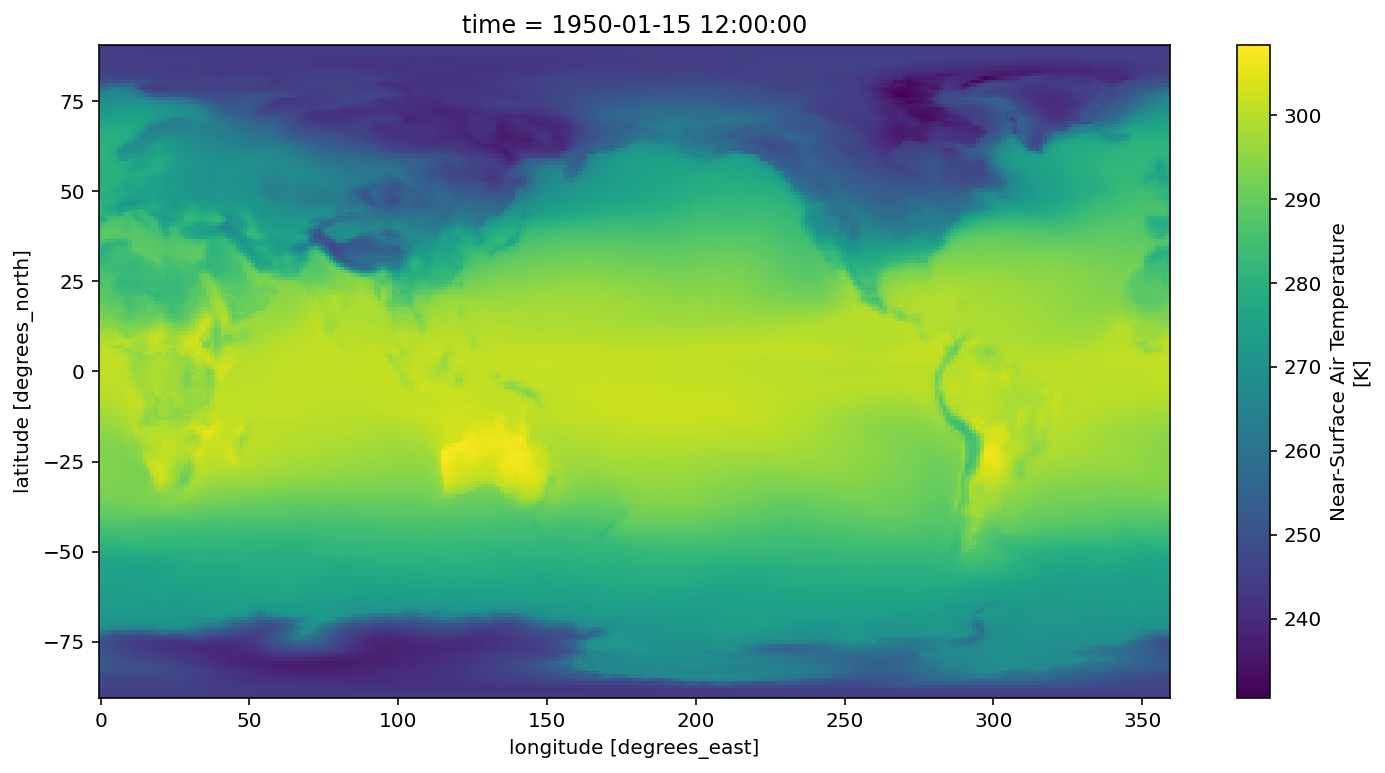

In [8]:
ds.tas.sel(time='1950-01').squeeze().plot()

Create a timeseries of global-average surface air temperature. For this we need the area weighting factor for each gridpoint.

In [10]:
df_area = df.query("variable_id == 'areacella' & source_id == 'CESM2'")
ds_area = xr.open_zarr(gcs.get_mapper(df_area.zstore.values[0]), consolidated=True)
ds_area

<xarray.Dataset>
Dimensions:    (lat: 192, lon: 288, nbnd: 2)
Coordinates:
  * lat        (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
    lat_bnds   (lat, nbnd) float64 dask.array<chunksize=(192, 2), meta=np.ndarray>
  * lon        (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
    lon_bnds   (lon, nbnd) float64 dask.array<chunksize=(288, 2), meta=np.ndarray>
Dimensions without coordinates: nbnd
Data variables:
    areacella  (lat, lon) float32 dask.array<chunksize=(192, 288), meta=np.ndarray>
Attributes:
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CFMIP
    branch_method:          no parent
    branch_time_in_child:   721970.0
    branch_time_in_parent:  0.0
    case_id:                965
    cesm_casename:          f.e21.FHIST_BGC.f09_f09_mg17.CFMIP-amip-4xCO2.001
    contact:                cesm_cmip6@ucar.edu
    creation_date:          2019-03-13T22:41:31Z
    data_specs_version:     01.00.29
    experiment:             Continuation of CFMIP-2 AMIP experiments and CMIP...
    experiment_id:          amip-4xCO2
    forcing_index:          1
    frequency:              fx
    further_info_url:       https://furtherinfo.es-doc.org/CMIP6.NCAR.CESM2.a...
    grid:                   native 0.9x1.25 finite volume grid (192x288 latxlon)
    grid_label:             gn
    initialization_index:   1
    institution:            National Center for Atmospheric Research, Climate...
    institution_id:         NCAR
    license:                CMIP6 model data produced by <The National Center...
    mip_era:                CMIP6
    model_doi_url:          https://doi.org/10.5065/D67H1H0V
    nominal_resolution:     100 km
    parent_activity_id:     no parent
    parent_experiment_id:   no parent
    parent_mip_era:         no parent
    parent_source_id:       no parent
    parent_time_units:      no parent
    parent_variant_label:   no parent
    physics_index:          1
    product:                model-output
    realization_index:      1
    realm:                  atmos land
    source:                 CESM2 (2017): atmosphere: CAM6 (0.9x1.25 finite v...
    source_id:              CESM2
    source_type:            AGCM AER
    sub_experiment:         none
    sub_experiment_id:      none
    table_id:               fx
    tracking_id:            hdl:21.14100/35b69461-eb69-4a58-b2f7-413dbf2cd8fe
    variable_id:            areacella
    variant_info:           The same as the amip experiment within DECK, exce...
    variant_label:          r1i1p1f1
    status:                 2019-11-04;created;by nhn2@columbia.edu

In [11]:
total_area = ds_area.areacella.sum(dim=['lon', 'lat'])
ta_timeseries = (ds.tas * ds_area.areacella).sum(dim=['lon', 'lat']) / total_area
ta_timeseries

<xarray.DataArray (time: 1980)>
dask.array<truediv, shape=(1980,), dtype=float32, chunksize=(600,), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 1850-01-15 12:00:00 ... 2014-12-15 12:00:00

By default the data are loaded lazily, as Dask arrays. Here we trigger computation explicitly.

In [12]:
%time ta_timeseries.load()

CPU times: user 5.26 s, sys: 2.89 s, total: 8.15 s
Wall time: 4.52 s


<xarray.DataArray (time: 1980)>
array([285.6408 , 285.57397, 286.33856, ..., 288.6992 , 287.76303,
       287.0621 ], dtype=float32)
Coordinates:
  * time     (time) object 1850-01-15 12:00:00 ... 2014-12-15 12:00:00

Text(0.5, 1.0, 'Global Mean Surface Air Temperature')

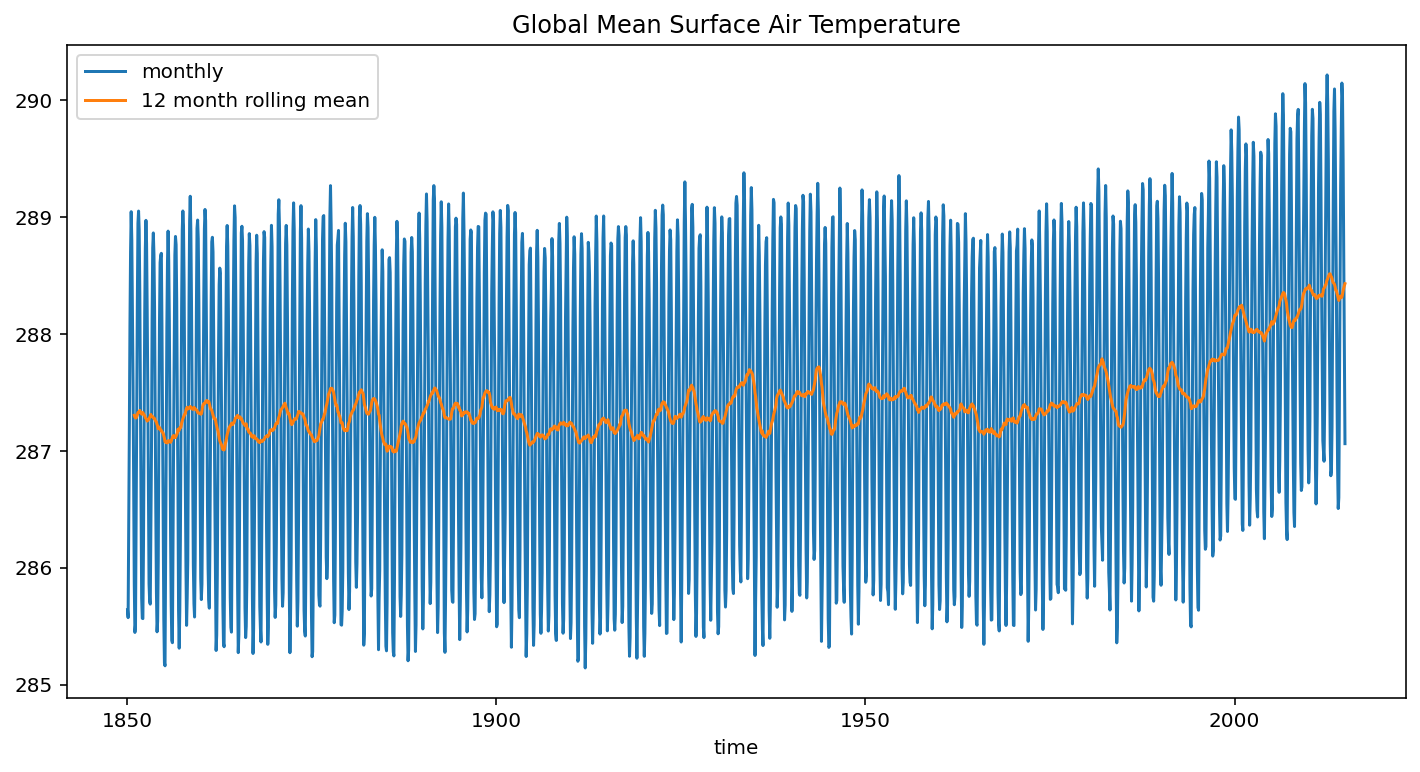

In [13]:
ta_timeseries.plot(label='monthly')
ta_timeseries.rolling(time=12).mean().plot(label='12 month rolling mean')
plt.legend()
plt.title('Global Mean Surface Air Temperature')